In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import numpy as np
from PIL import Image


### Creating Segmentation masks

In [2]:
SUBSETS = ['train', 'val', 'test']
ROOT_IMG = '/kaggle/input/cityscapes-leftimg8bit-trainvaltest/leftImg8bit'
ROOT_GT = '/kaggle/input/gtfine-trainvaltest/gtFine'
OUTPUT_ROOT = '/kaggle/working/masks'

VALID_CLASSES = {
    7: 0, 8: 1, 11: 2, 12: 3, 13: 4,
    17: 5, 19: 6, 20: 7, 21: 8, 22: 9,
    23: 10, 24: 11, 25: 12, 26: 13, 27: 14,
    28: 15, 31: 16, 32: 17, 33: 18
}

def convert_mask(gt_path, out_path):
    mask = np.array(Image.open(gt_path))
    multi_class_mask = 255 * np.ones_like(mask, dtype=np.uint8)
    for orig_label, new_label in VALID_CLASSES.items():
        multi_class_mask[mask == orig_label] = new_label
    Image.fromarray(multi_class_mask).save(out_path)

def process_subset(split, max_images=8000):
    img_dir = os.path.join(ROOT_IMG, split)
    gt_dir = os.path.join(ROOT_GT, split)
    out_dir = os.path.join(OUTPUT_ROOT, split)
    os.makedirs(out_dir, exist_ok=True)

    count = 0
    
    for city in os.listdir(img_dir):
        city_img_dir = os.path.join(img_dir, city)
        city_gt_dir = os.path.join(gt_dir, city)
        for file in tqdm(os.listdir(city_img_dir), desc=f"{split} - {city}"):
            if count >= max_images:
                return
            if file.endswith('_leftImg8bit.png'):
                img_id = file.replace('_leftImg8bit.png', '')
                gt_file = os.path.join(city_gt_dir, f"{img_id}_gtFine_labelIds.png")
                out_file = os.path.join(out_dir, f"{img_id}_mask.png")
                if os.path.exists(gt_file):
                    try:
                        convert_mask(gt_file, out_file)
                        count += 1
                    except Exception as e:
                        print(f"Error: {gt_file} - {e}")
                else:
                    print(f"Missing annotation: {gt_file}")


In [3]:
for split in SUBSETS:
    process_subset(split=split, max_images=5000)

print("✅ All masks generated based on official splits!")


test - bonn: 100%|██████████| 46/46 [00:01<00:00, 25.81it/s]

✅ All masks generated based on official splits!


In [4]:
import os

print("Train mask samples:", os.listdir('/kaggle/working/masks/train')[:5])
print("Val mask samples:", os.listdir('/kaggle/working/masks/val')[:5])
print("Test mask samples:", os.listdir('/kaggle/working/masks/test')[:5])


Train mask samples: ['hamburg_000000_077144_mask.png', 'ulm_000018_000019_mask.png', 'bremen_000032_000019_mask.png', 'monchengladbach_000000_011383_mask.png', 'bremen_000254_000019_mask.png']
Val mask samples: ['munster_000083_000019_mask.png', 'frankfurt_000001_067735_mask.png', 'frankfurt_000001_073464_mask.png', 'munster_000143_000019_mask.png', 'munster_000016_000019_mask.png']
Test mask samples: ['bielefeld_000000_014068_mask.png', 'bonn_000015_000019_mask.png', 'berlin_000509_000019_mask.png', 'mainz_000000_021833_mask.png', 'leverkusen_000003_000019_mask.png']


### Visualizing some segmentation masks in images

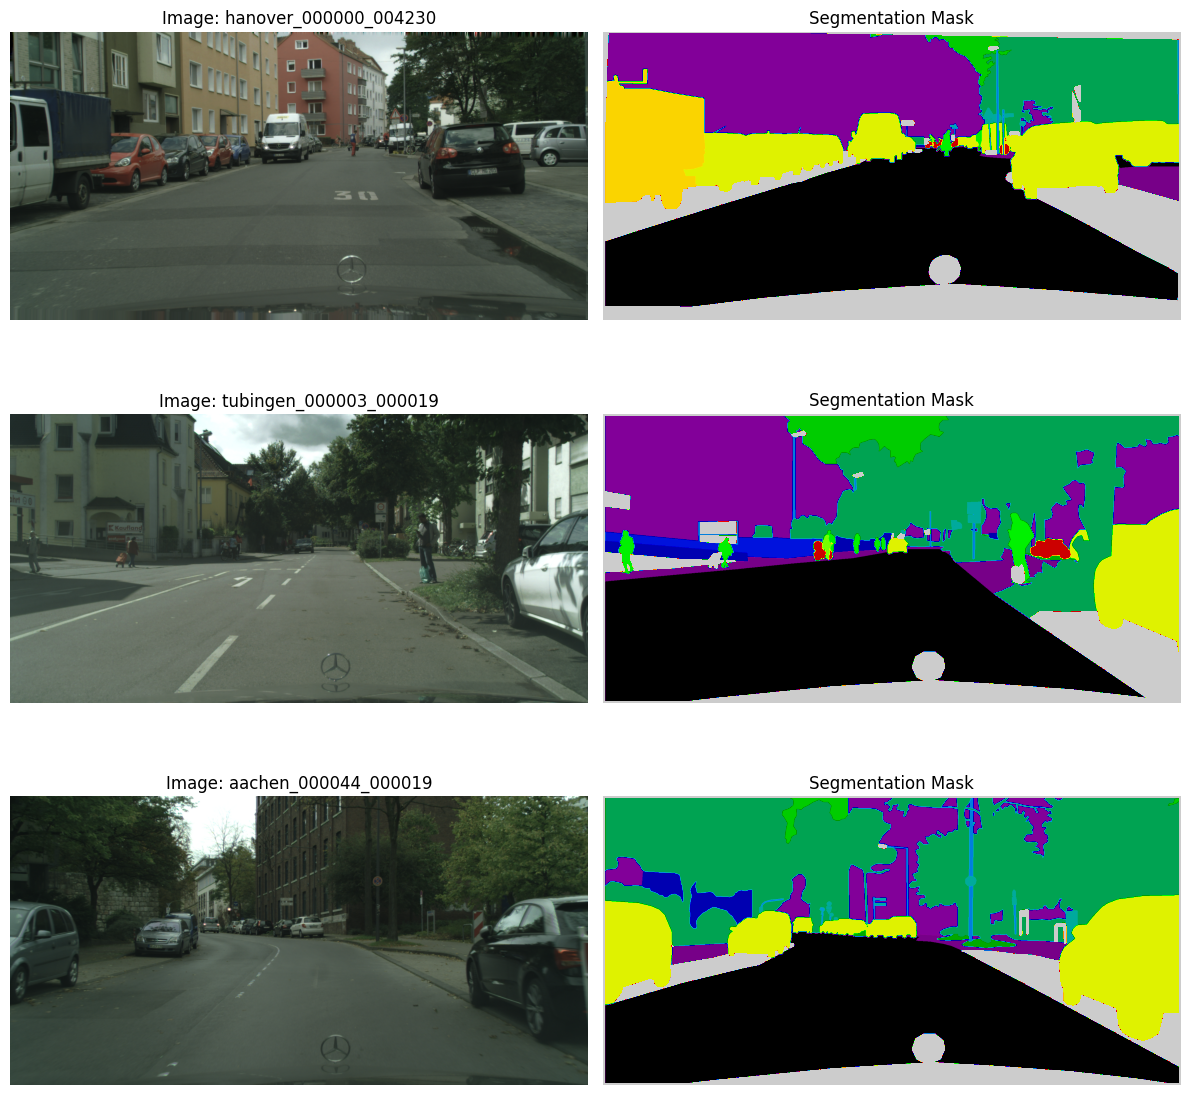

In [5]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

def visualize_samples(img_dir, mask_dir, num_samples=3):
    """
    Visualizes random sample pairs of original images and their segmentation masks.
    """
    sample_images = []
    
    # Check if directories exist for the given subset (train, val, test)
    if not os.path.exists(img_dir) or not os.path.exists(mask_dir):
        print(f"Error: {img_dir} or {mask_dir} does not exist!")
        return
    
    # Collect image paths
    for city in os.listdir(img_dir):
        city_dir = os.path.join(img_dir, city)
        if not os.path.isdir(city_dir):
            continue
        for file in os.listdir(city_dir):
            if file.endswith('_leftImg8bit.png'):
                sample_images.append(os.path.join(city_dir, file))
    
    if not sample_images:
        print("No images found!")
        return
    
    # Randomly sample images
    samples = random.sample(sample_images, num_samples)
    
    # Plot images and corresponding masks
    fig, axes = plt.subplots(num_samples, 2, figsize=(12, 4 * num_samples))
    for i, img_path in enumerate(samples):
        img = Image.open(img_path)
        img_id = os.path.basename(img_path).replace('_leftImg8bit.png', '')
        
        # Adjust mask path to match the name convention
        mask_path = os.path.join(mask_dir, f"{img_id}_mask.png")
        
        # If mask is missing, print a message and skip this sample
        if not os.path.exists(mask_path):
            print(f"Mask not found for {img_id}")
            continue
        
        mask = Image.open(mask_path)
        
        # Display the image and mask side by side
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f"Image: {img_id}")
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(mask, cmap='nipy_spectral', vmin=0, vmax=19)  # adjust class range
        axes[i, 1].set_title("Segmentation Mask")
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage: Visualize sample image and mask pairs
train_img_dir = '/kaggle/input/cityscapes-leftimg8bit-trainvaltest/leftImg8bit/train'
train_mask_dir = '/kaggle/working/masks/train'

visualize_samples(train_img_dir, train_mask_dir, num_samples=3)


### Creating dataset for model

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Define Dataset Class
class CityscapesDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        
        # Get all image files from all city subdirectories
        self.image_paths = []
        for city in os.listdir(img_dir):
            city_img_dir = os.path.join(img_dir, city)
            if os.path.isdir(city_img_dir):
                for file in os.listdir(city_img_dir):
                    if file.endswith('_leftImg8bit.png'):
                        self.image_paths.append(os.path.join(city, file))
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Get image path
        rel_img_path = self.image_paths[idx]
        img_path = os.path.join(self.img_dir, rel_img_path)
        img = Image.open(img_path)
        
        # Get corresponding mask path
        img_id = os.path.basename(rel_img_path).replace('_leftImg8bit.png', '')
        mask_path = os.path.join(self.mask_dir, f"{img_id}_mask.png")
        mask = Image.open(mask_path)
        
        # Convert PIL images to numpy arrays
        img = np.array(img)
        mask = np.array(mask)
        
        # Apply transformations if any
        if self.transform:
            transformed = self.transform(image=img, mask=mask)
            img = transformed['image']
            mask = transformed['mask']
        
        return img, mask

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [7]:
# Define Albumentations transformations
IMAGE_SIZE = 512  # Set image size for SegFormer
train_transform = A.Compose([
    A.RandomCrop(width=IMAGE_SIZE, height=IMAGE_SIZE),
    A.HorizontalFlip(p=0.5),
    A.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.CenterCrop(width=IMAGE_SIZE, height=IMAGE_SIZE),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

# Instantiate datasets
train_img_dir = os.path.join(ROOT_IMG, 'train')
train_mask_dir = os.path.join(OUTPUT_ROOT, 'train')
val_img_dir = os.path.join(ROOT_IMG, 'val')
val_mask_dir = os.path.join(OUTPUT_ROOT, 'val')

# Instantiate datasets
train_dataset = CityscapesDataset(train_img_dir, train_mask_dir, transform=train_transform)
val_dataset = CityscapesDataset(val_img_dir, val_mask_dir, transform=val_transform)

# Create DataLoaders
BATCH_SIZE = 8
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)



### Creating the architecture for U-Net

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

# Define the U-Net model components
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=19, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        # Encoder path
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        
        # Decoder path
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        # Encoder
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        # Decoder with skip connections
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        
        return logits

### Wandb installation

In [10]:
# First, install wandb if you haven't already
!pip install wandb

# Import wandb at the top of your notebook
import wandb

### Calculation of metrics

In [14]:
# Ensure model is on GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
model = model.to(device)

# Define the metrics calculation function
def calculate_metrics(model, dataloader, device, num_classes):
    model.eval()
    total_iou = 0
    total_correct = 0
    total_pixels = 0
    
    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            
            # Calculate IoU
            for cls in range(num_classes):
                pred_cls = (preds == cls)
                mask_cls = (masks == cls)
                intersection = (pred_cls & mask_cls).sum().item()
                union = (pred_cls | mask_cls).sum().item()
                if union > 0:
                    total_iou += intersection / union
            
            # Calculate pixel accuracy
            valid_mask = masks != 255
            correct = ((preds == masks) & valid_mask).sum().item()
            total_correct += correct
            total_pixels += valid_mask.sum().item()
    
    mean_iou = total_iou / (num_classes * len(dataloader))
    pixel_accuracy = total_correct / total_pixels if total_pixels > 0 else 0
    
    return {
        'mean_iou': mean_iou,
        'pixel_accuracy': pixel_accuracy
    }


Using device: cuda


In [17]:
# Function to get example predictions
def get_example_images(model, dataloader, device, num_examples=3):
    model.eval()
    images, masks = next(iter(dataloader))
    images = images[:num_examples].to(device)
    masks = masks[:num_examples].cpu().numpy()
    
    with torch.no_grad():
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
    
    # Convert to format expected by wandb
    examples = []
    for i in range(num_examples):
        # Convert tensor to numpy for wandb
        img = images[i].cpu().numpy().transpose(1, 2, 0)  # CHW -> HWC
        # Denormalize if needed
        img = img * 0.5 + 0.5  # Assuming normalization was done with mean=0.5, std=0.5
        
        # Create class labels dictionary
        class_labels = {v: f"Class {k}" for k, v in VALID_CLASSES.items()}
        
        examples.append((img, preds[i], masks[i]))
    
    return examples

# Training loop
num_epochs = 10
best_val_loss = float('inf')

# Initialize wandb
wandb.init(project="cityscapes-segmentation", name="unet-experiment")

# Log hyperparameters
wandb.config.update({
    "learning_rate": 1e-4,
    "epochs": num_epochs,
    "batch_size": 8,
    "model": "UNet",
    "optimizer": "Adam"
})

### Training 

In [18]:
# Training function
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    
    # Use tqdm for progress bar
    with tqdm(dataloader, desc="Training") as pbar:
        for images, masks in pbar:
            images = images.to(device)
            masks = masks.to(device).long()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            pbar.set_postfix(loss=loss.item())
    
    return total_loss / len(dataloader)

# Validation function
def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        with tqdm(dataloader, desc="Validating") as pbar:
            for images, masks in pbar:
                images = images.to(device)
                masks = masks.to(device).long()
                
                outputs = model(images)
                loss = criterion(outputs, masks)
                
                total_loss += loss.item()
                pbar.set_postfix(loss=loss.item())
    
    return total_loss / len(dataloader)

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    
    # Train
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    
    # Validate
    val_loss = validate(model, val_loader, criterion, device)
    
    print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    # Calculate metrics
    metrics = calculate_metrics(model, val_loader, device, num_classes=len(VALID_CLASSES))
    print(f"Mean IoU: {metrics['mean_iou']:.4f}, Pixel Accuracy: {metrics['pixel_accuracy']:.4f}")
    
    # Log metrics
    wandb.log({
        "epoch": epoch,
        "train_loss": train_loss,
        "val_loss": val_loss,
        "mean_iou": metrics["mean_iou"],
        "pixel_accuracy": metrics["pixel_accuracy"]
    })
    
    # Log example predictions every 5 epochs
    if epoch % 5 == 0:
        # Get example predictions
        example_images = get_example_images(model, val_loader, device)
        
        # Create class labels dictionary
        class_labels = {v: f"Class {k}" for k, v in VALID_CLASSES.items()}
        
        # Log images to wandb
        wandb_images = []
        for img, pred, mask in example_images:
            wandb_images.append(
                wandb.Image(
                    img,
                    masks={
                        "predictions": {"mask_data": pred, "class_labels": class_labels},
                        "ground_truth": {"mask_data": mask, "class_labels": class_labels}
                    }
                )
            )
        
        wandb.log({"predictions": wandb_images})
    
    # Update learning rate
    scheduler.step(val_loss)
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_unet_model.pth')
        print("Saved best model!")
    
    print("-" * 40)

print("Training completed!")
wandb.finish()


Epoch 1/10


Validating: 100%|██████████| 63/63 [00:38<00:00,  1.63it/s, loss=0.74] 

Train Loss: 1.1362, Val Loss: 0.8745


Mean IoU: 0.1438, Pixel Accuracy: 0.7578
Saved best model!
----------------------------------------

Epoch 2/10


Validating: 100%|██████████| 63/63 [00:38<00:00,  1.63it/s, loss=0.604]

Train Loss: 0.9751, Val Loss: 0.6949


Mean IoU: 0.1848, Pixel Accuracy: 0.8121
Saved best model!
----------------------------------------

Epoch 3/10


Validating: 100%|██████████| 63/63 [00:38<00:00,  1.62it/s, loss=0.768]

Train Loss: 0.8624, Val Loss: 0.9254


Mean IoU: 0.1472, Pixel Accuracy: 0.7141
----------------------------------------

Epoch 4/10


Validating: 100%|██████████| 63/63 [00:38<00:00,  1.62it/s, loss=0.635]

Train Loss: 0.8123, Val Loss: 0.6539


Mean IoU: 0.1990, Pixel Accuracy: 0.8230
Saved best model!
----------------------------------------

Epoch 5/10


Validating: 100%|██████████| 63/63 [00:38<00:00,  1.62it/s, loss=0.484]

Train Loss: 0.7521, Val Loss: 0.5612


Mean IoU: 0.2146, Pixel Accuracy: 0.8485
Saved best model!
----------------------------------------

Epoch 6/10


Validating: 100%|██████████| 63/63 [00:38<00:00,  1.62it/s, loss=0.581]

Train Loss: 0.7027, Val Loss: 0.6441


Mean IoU: 0.1905, Pixel Accuracy: 0.8177
----------------------------------------

Epoch 7/10


Validating: 100%|██████████| 63/63 [00:38<00:00,  1.62it/s, loss=0.429]

Train Loss: 0.6971, Val Loss: 0.4830


Mean IoU: 0.2325, Pixel Accuracy: 0.8676
Saved best model!
----------------------------------------

Epoch 8/10


Validating: 100%|██████████| 63/63 [00:38<00:00,  1.62it/s, loss=0.428]

Train Loss: 0.6439, Val Loss: 0.4868


Mean IoU: 0.2396, Pixel Accuracy: 0.8680
----------------------------------------

Epoch 9/10


Validating: 100%|██████████| 63/63 [00:38<00:00,  1.62it/s, loss=0.443]

Train Loss: 0.6234, Val Loss: 0.5071


Mean IoU: 0.2399, Pixel Accuracy: 0.8514
----------------------------------------

Epoch 10/10


Validating: 100%|██████████| 63/63 [00:39<00:00,  1.61it/s, loss=0.399]

Train Loss: 0.5968, Val Loss: 0.4671


Mean IoU: 0.2441, Pixel Accuracy: 0.8700
Saved best model!
----------------------------------------
Training completed!


epoch,▁▁▂▃▃▄▅▆▆▇█
mean_iou,▁▄▁▅▆▄▇███
pixel_accuracy,▃▅▁▆▇▆██▇█
train_loss,█▄▃▃▂▂▂▂▁▁▁
val_loss,█▅▃▆▃▂▃▁▁▁▁
epoch,9
mean_iou,0.24408
pixel_accuracy,0.86996
train_loss,0.59682
val_loss,0.46705


### Different Metrics 

In [23]:
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def calculate_metrics(model, dataloader, device, num_classes):
    """
    Calculate IoU, Dice coefficient, and pixel accuracy for the model
    """
    model.eval()
    
    # Initialize confusion matrix
    conf_matrix = np.zeros((num_classes, num_classes))
    
    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc="Calculating metrics"):
            images = images.to(device)
            masks = masks.cpu().numpy()
            
            # Get predictions
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            
            # Update confusion matrix
            for i in range(len(masks)):
                # Flatten the arrays
                mask_flat = masks[i].flatten()
                pred_flat = preds[i].flatten()
                
                # Only consider valid pixels (not 255)
                valid_pixels = mask_flat != 255
                mask_valid = mask_flat[valid_pixels]
                pred_valid = pred_flat[valid_pixels]
                
                # Update confusion matrix
                cm = confusion_matrix(mask_valid, pred_valid, 
                                     labels=range(num_classes))
                conf_matrix += cm
    
    # Calculate metrics
    # 1. Per-class IoU
    intersection = np.diag(conf_matrix)
    union = (np.sum(conf_matrix, axis=1) + np.sum(conf_matrix, axis=0) - intersection)
    class_iou = intersection / (union + 1e-10)
    
    # 2. Mean IoU
    mean_iou = np.mean(class_iou)
    
    # 3. Per-class Dice coefficient
    dice = (2 * intersection) / (np.sum(conf_matrix, axis=1) + np.sum(conf_matrix, axis=0) + 1e-10)
    
    # 4. Mean Dice coefficient
    mean_dice = np.mean(dice)
    
    # 5. Pixel accuracy
    pixel_accuracy = np.sum(intersection) / np.sum(conf_matrix)
    
    
    
    return {
        'confusion_matrix': conf_matrix,
        'class_iou': class_iou,
        'mean_iou': mean_iou,
        'class_dice': dice,
        'mean_dice': mean_dice,
        'pixel_accuracy': pixel_accuracy,
    }

def visualize_metrics(metrics, class_names=None):
    """
    Visualize the calculated metrics
    """
    if class_names is None:
        class_names = [f'Class {i}' for i in range(len(metrics['class_iou']))]
    
    # Plot IoU and Dice per class
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # IoU plot
    ax1.bar(class_names, metrics['class_iou'])
    ax1.set_title(f'IoU per class (Mean: {metrics["mean_iou"]:.4f})')
    ax1.set_ylabel('IoU')
    ax1.set_xlabel('Class')
    ax1.set_ylim(0, 1)
    ax1.axhline(y=metrics['mean_iou'], color='r', linestyle='--')
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
    
    # Dice plot
    ax2.bar(class_names, metrics['class_dice'])
    ax2.set_title(f'Dice coefficient per class (Mean: {metrics["mean_dice"]:.4f})')
    ax2.set_ylabel('Dice coefficient')
    ax2.set_xlabel('Class')
    ax2.set_ylim(0, 1)
    ax2.axhline(y=metrics['mean_dice'], color='r', linestyle='--')
    plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
    
    
    
    # Print summary
    print(f"Overall Metrics:")
    print(f"Mean IoU: {metrics['mean_iou']:.4f}")
    print(f"Mean Dice: {metrics['mean_dice']:.4f}")
    print(f"Pixel Accuracy: {metrics['pixel_accuracy']:.4f}")
    

def visualize_predictions(model, dataloader, device, num_samples=5, class_colors=None):
    """
    Visualize model predictions alongside ground truth
    """
    model.eval()
    
    # Generate random colors for classes if not provided
    num_classes = len(VALID_CLASSES)
    if class_colors is None:
        np.random.seed(42)
        class_colors = [
            np.random.randint(0, 256, 3).tolist() for _ in range(num_classes)
        ]
        # Add color for ignored pixels (255)
        class_colors.append([0, 0, 0])
    
    # Get samples
    images, masks = next(iter(dataloader))
    images = images[:num_samples].to(device)
    masks = masks[:num_samples].cpu().numpy()
    
    # Get predictions
    with torch.no_grad():
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
    
    # Denormalize images
    images = images.cpu().numpy()
    images = np.transpose(images, (0, 2, 3, 1))  # NCHW -> NHWC
    images = images * 0.5 + 0.5  # Denormalize
    
    # Create color-coded masks
    def color_code_mask(mask):
        color_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
        for class_idx, color in enumerate(class_colors):
            color_mask[mask == class_idx] = color
        return color_mask
    
    # Visualize
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    
    for i in range(num_samples):
        # Original image
        axes[i, 0].imshow(images[i])
        axes[i, 0].set_title('Original Image')
        axes[i, 0].axis('off')
        
        # Ground truth
        gt_colored = color_code_mask(masks[i])
        axes[i, 1].imshow(gt_colored)
        axes[i, 1].set_title('Ground Truth')
        axes[i, 1].axis('off')
        
        # Prediction
        pred_colored = color_code_mask(preds[i])
        axes[i, 2].imshow(pred_colored)
        axes[i, 2].set_title('Prediction')
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return images, masks, preds


/tmp/ipykernel_31/1334143221.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_unet_model.pth'))
Calculating metrics: 100%|█████████

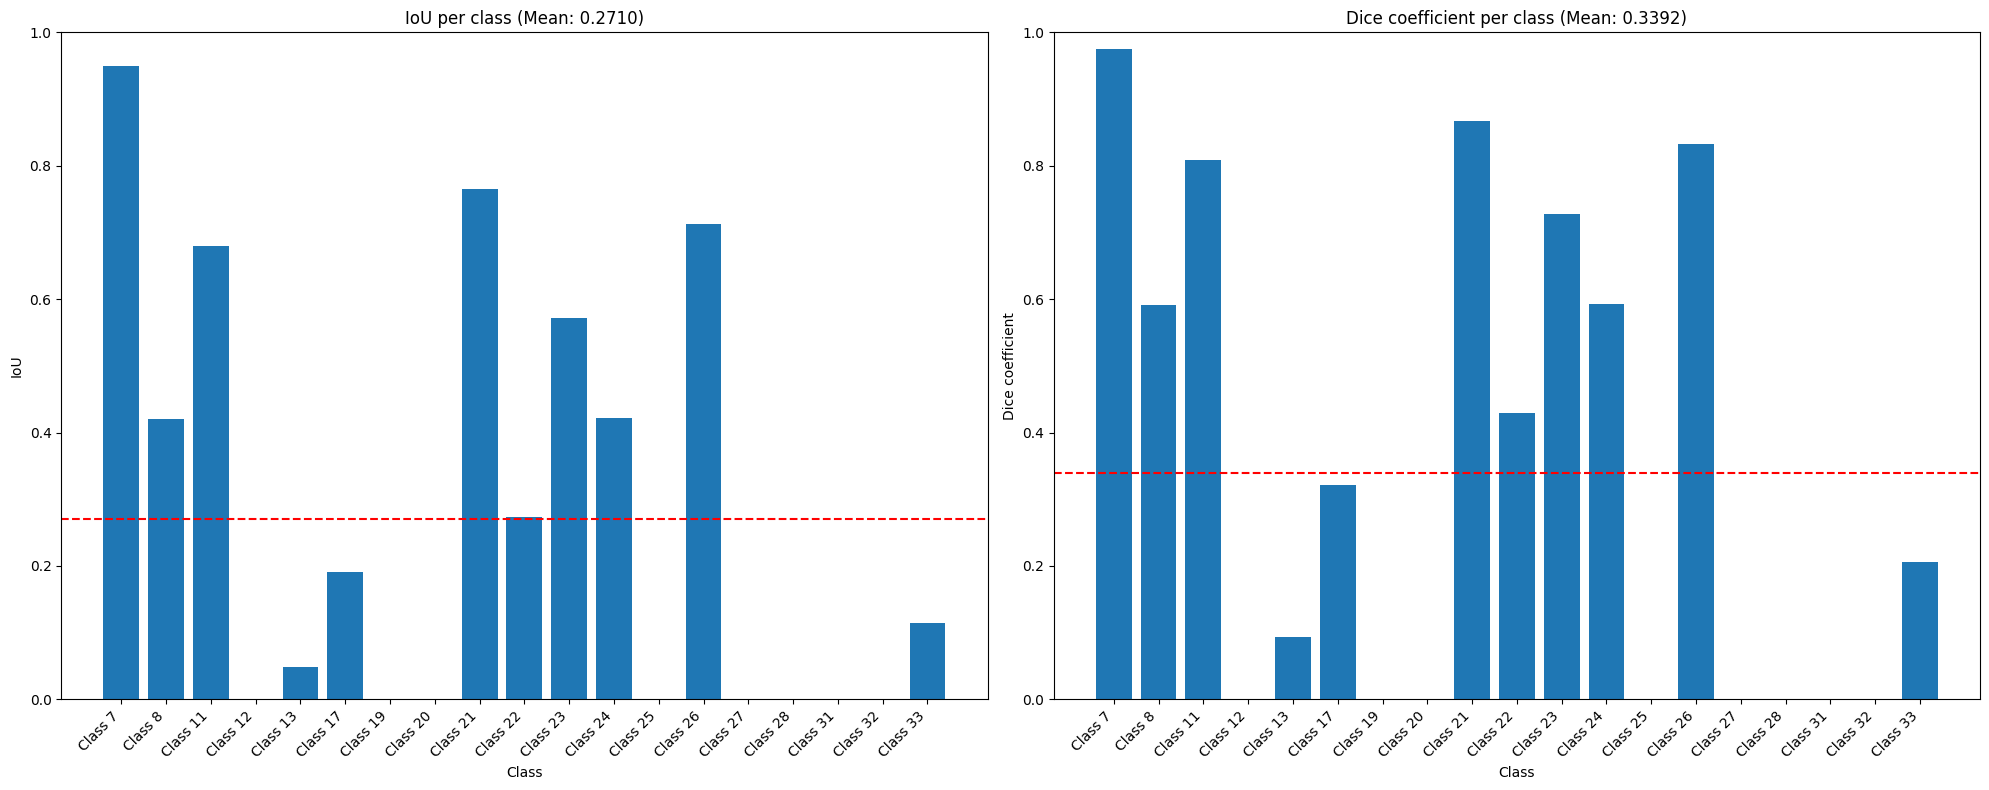

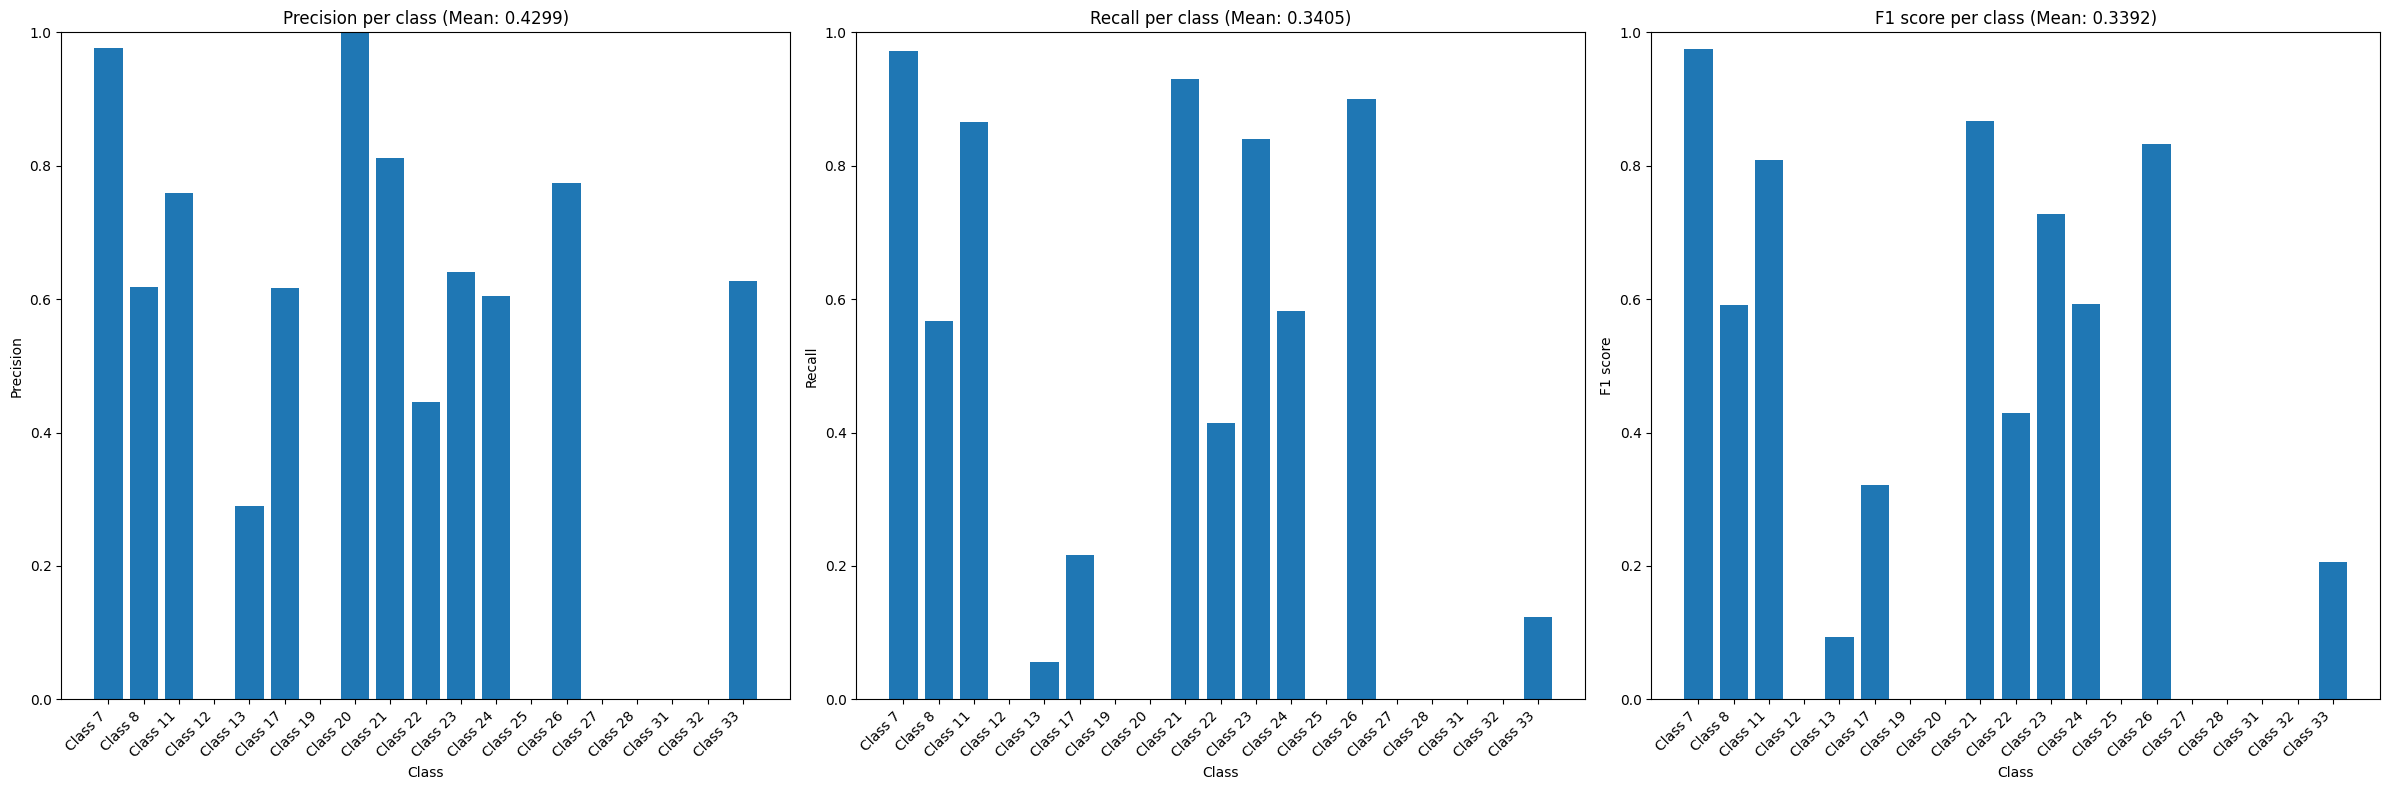

Overall Metrics:
Mean IoU: 0.2710
Mean Dice: 0.3392
Pixel Accuracy: 0.8700
Mean F1 Score: 0.3392


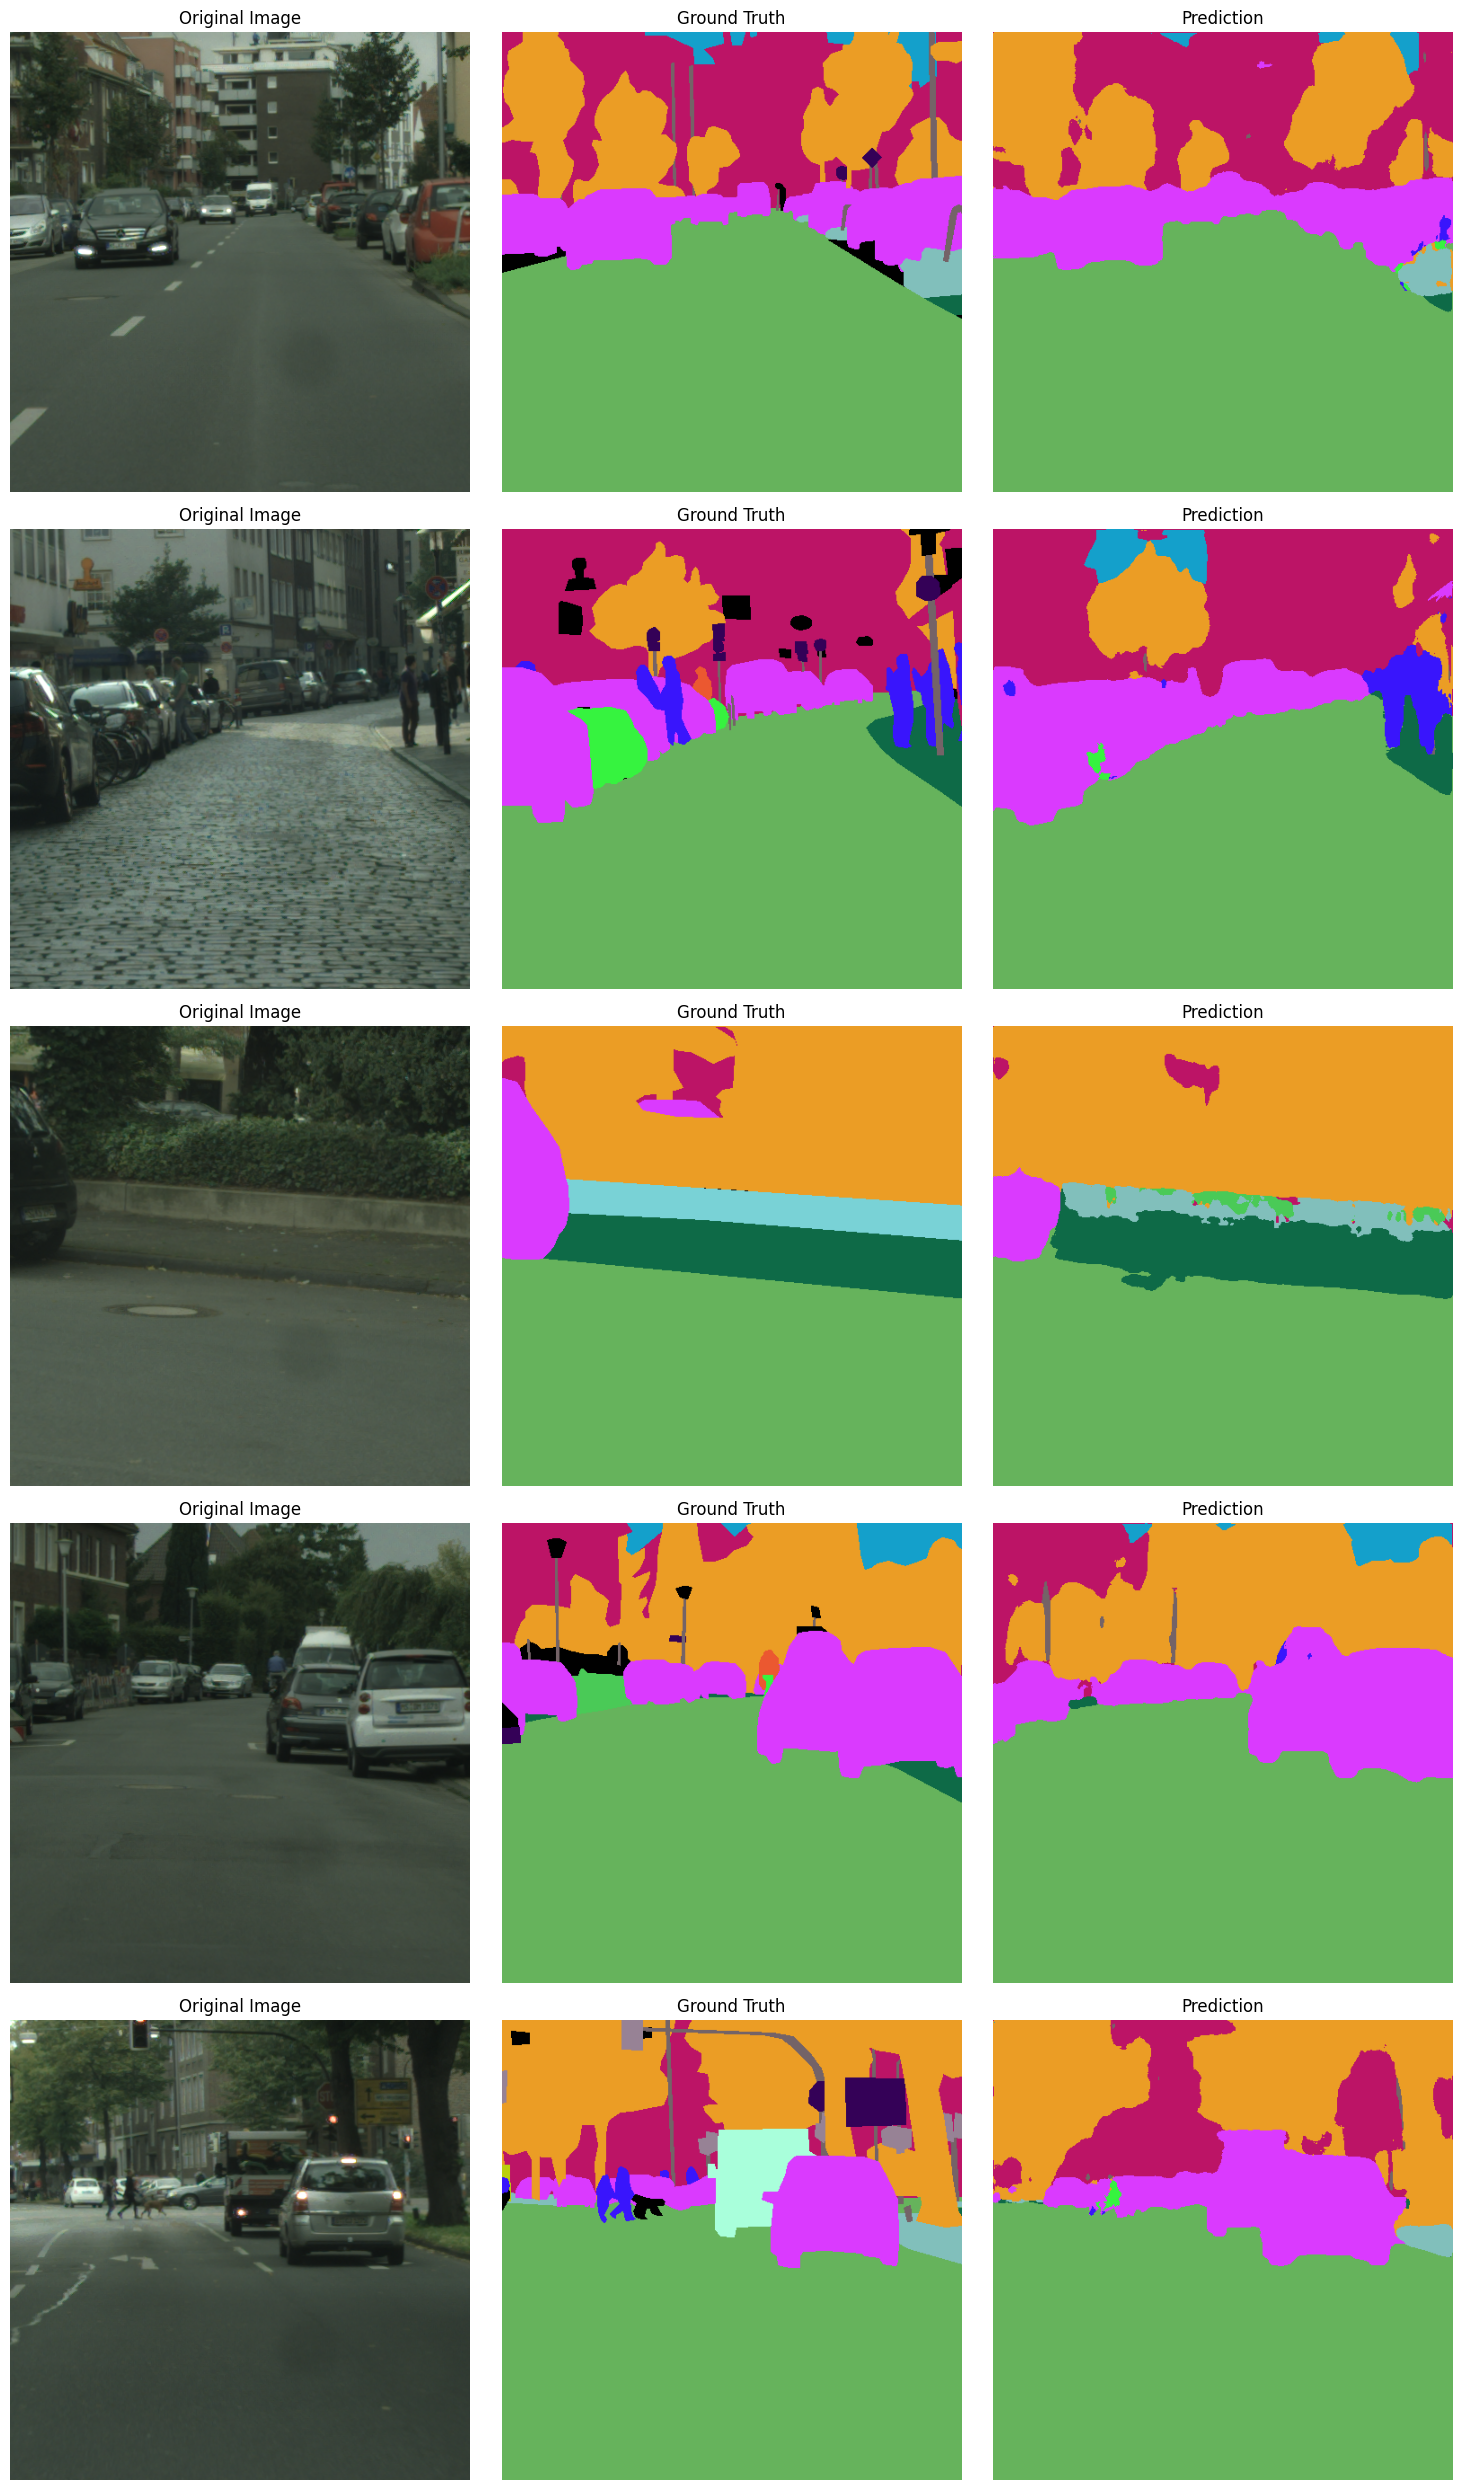

(array([[[[0.29019606, 0.372549  , 0.30196077],
          [0.27058822, 0.35294116, 0.2745098 ],
          [0.21568626, 0.32549018, 0.25098038],
          ...,
          [0.53333336, 0.50980395, 0.38823527],
          [0.53333336, 0.50980395, 0.39215684],
          [0.5294118 , 0.50980395, 0.39215684]],
 
         [[0.19999999, 0.29019606, 0.2352941 ],
          [0.17647058, 0.25098038, 0.18823528],
          [0.15294117, 0.22745097, 0.1607843 ],
          ...,
          [0.5372549 , 0.50980395, 0.38823527],
          [0.5372549 , 0.5137255 , 0.39215684],
          [0.53333336, 0.50980395, 0.39215684]],
 
         [[0.16470587, 0.24313724, 0.19999999],
          [0.15294117, 0.21568626, 0.16470587],
          [0.16862744, 0.20784312, 0.15686274],
          ...,
          [0.5294118 , 0.50980395, 0.3843137 ],
          [0.53333336, 0.50980395, 0.39215684],
          [0.53333336, 0.50980395, 0.39215684]],
 
         ...,
 
         [[0.25098038, 0.29019606, 0.25490195],
          [0.25490

In [24]:
# Load your best model
model.load_state_dict(torch.load('best_unet_model.pth'))

# Calculate metrics on validation set
metrics = calculate_metrics(model, val_loader, device, num_classes=len(VALID_CLASSES))

# Create class names based on your VALID_CLASSES mapping
# Reverse the mapping to get original class IDs
reverse_mapping = {v: k for k, v in VALID_CLASSES.items()}
class_names = [f'Class {reverse_mapping[i]}' for i in range(len(VALID_CLASSES))]

# Visualize metrics
visualize_metrics(metrics, class_names)

# Visualize some predictions
visualize_predictions(model, val_loader, device, num_samples=5)
